## Regression Problem: Wind Production Prediction
In this exercise, we will solve a regression problem with a neural network.

**Objective:** The goal is to predict the electricity production of windmills in France.

**Dataset:**  A csv file with 8 784 samples from the year 2016 is provided (on the course webpage). Each example contains three input features describing the weather at that time. We will use 6 000 examples as training set, 1 000 as validation set and the rest as test set.   
   * **Feature names**: FR_windspeed_10, FR_temperature, FR_radiation_direct_horizontal
   * **Target**: FR_wind_onshore_generation_actual

**NB:** new required libraries: `pandas`, `seaborn`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns

%matplotlib inline

In [2]:
# Load data:
df = pd.read_csv("FR_wind_predict_2016.csv", parse_dates=[0], index_col=0)

In [3]:
df.head(3)

,FR_wind_onshore_generation_actual,FR_windspeed_10m,FR_temperature,FR_radiation_direct_horizontal
utc_timestamp,,,,
2016-01-01 00:00:00,2082.0,2.86,5.571,0.0
2016-01-01 01:00:00,1690.0,2.68,5.415,0.0
2016-01-01 02:00:00,1414.0,2.51,5.288,0.0


In [4]:
df.info() # get more information

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8783 entries, 2016-01-01 00:00:00 to 2016-12-31 22:00:00
Data columns (total 4 columns):
FR_wind_onshore_generation_actual    8783 non-null float64
FR_windspeed_10m                     8783 non-null float64
FR_temperature                       8783 non-null float64
FR_radiation_direct_horizontal       8783 non-null float64
dtypes: float64(4)
memory usage: 343.1 KB


### Data Analysis
Before training, we need first to analyze the dataset, to know its properties better.

(0, 10000)

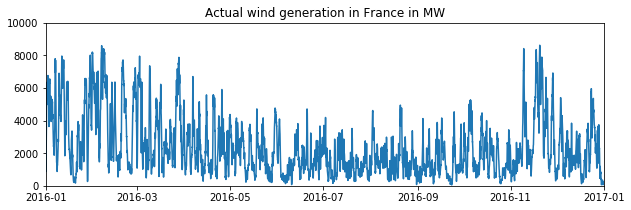

In [5]:

plt.figure(figsize=(10, 3))
plt.plot(df.index, df['FR_wind_onshore_generation_actual'])
plt.title('Actual wind generation in France in MW')
plt.xlim(pd.Timestamp('2016-01-01'), pd.Timestamp('2017-01-01'))
plt.ylim(0, 10000)

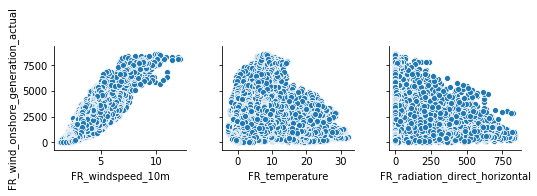

In [6]:
sns.pairplot(df, x_vars=['FR_windspeed_10m', 'FR_temperature', 'FR_radiation_direct_horizontal'], y_vars=['FR_wind_onshore_generation_actual'])

### Wind prediction

Here is a skeleton of a neural network with a single layer (thus: a linear classifier). This is the model you'll start with and improve during this exercise.

Look at the code and run it to see its structure, then follow the questions below to iteratively improve the model.

In [7]:
X_wind = df[['FR_windspeed_10m', 'FR_temperature', 'FR_radiation_direct_horizontal']] # get the three features from the dataframe
y_wind = df["FR_wind_onshore_generation_actual"] # get the target values

#### Normalizing the data

In [30]:
X_wind_max = np.max(X_wind)
y_wind_max = np.max(y_wind)

X_wind = X_wind/X_wind_max
y_wind = y_wind/y_wind_max

In [175]:
print(X_wind.shape)

(8783, 3)


In [31]:
X_train = X_wind.iloc[:6000]
y_train = y_wind.iloc[:6000]

X_val = X_wind.iloc[6000:7000]
y_val = y_wind.iloc[6000:7000]

X_test = X_wind.iloc[7000:]
y_test = y_wind.iloc[7000:]

In [32]:
# Construct a model with one layer
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.l1 = nn.Linear(3, 1)
        
    def forward(self, inputs):
        outputs = self.l1(inputs)
        return outputs

In [33]:
# Define hyper-parameters:
model = Model()

# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 10

# Training criterion. This one is a mean squared error (MSE) loss between the output
# of the network and the target label
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [34]:
train_set = TensorDataset(torch.from_numpy(np.array(X_train)).float(), 
                          torch.from_numpy(np.array(y_train)).float()) # create the dataset.

In [52]:
def train(num_epochs, batch_size, criterion, optimizer, model, dataset):
    train_error = []
    
    dataloader = DataLoader(dataset, batch_size, shuffle=True)

    model.train()
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (X, y) in (dataloader):

            y_pre = model(X).view(-1)
            loss = criterion(y_pre, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(train_set)
            
        if ((epoch+1)%1 == 0):
            print('Epoch [{}/{}], Loss_error: {:.4f}'
                      .format(epoch+1, num_epochs,  epoch_average_loss))
            train_error.append(epoch_average_loss)
            
    return train_error

In [36]:
train(num_epochs, batch_size, criterion, optimizer, model, train_set)

Epoch [1/10], Loss_error: 0.0550
Epoch [2/10], Loss_error: 0.0365
Epoch [3/10], Loss_error: 0.0267
Epoch [4/10], Loss_error: 0.0205
Epoch [5/10], Loss_error: 0.0165
Epoch [6/10], Loss_error: 0.0138
Epoch [7/10], Loss_error: 0.0119
Epoch [8/10], Loss_error: 0.0105
Epoch [9/10], Loss_error: 0.0096
Epoch [10/10], Loss_error: 0.0089


### Defining accuracy function 

In [41]:
# Calculate mean squared error on validation set
def accuracy(X_val,y_val,model):
    with torch.no_grad():
        y_pre_val = model(torch.from_numpy(np.array(X_val)).float()).view(-1)
    error = criterion(y_pre_val, torch.tensor(np.array(y_val)).float()).item()
    print('The loss on validation set is:', error)
    return error

### Question 1

In [45]:
# Construct a model with one layer
class Model(nn.Module):
    
    def __init__(self,neurons,acti):
        super(Model, self).__init__()
        
        self.l1 = nn.Linear(3, 1)
        
    def forward(self, inputs):
        outputs = self.l1(inputs)
        return outputs

In [38]:
class Model_2(nn.Module):
    
    def __init__(self,neurons,acti):
        super(Model_2, self).__init__()
        self.l1 = nn.Linear(3, neurons)
        self.l2 = nn.Linear(neurons, 1)
        self.acti=acti
        
    def forward(self, inputs):
        outputs = self.l1(inputs)
        outputs = self.acti(outputs)
        outputs = self.l2(outputs)

        return outputs

In [39]:
class Model_3(nn.Module):
    
    def __init__(self,neurons,acti):
        super(Model_3, self).__init__()
        self.l1 = nn.Linear(3, neurons)
        self.l2 = nn.Linear(neurons, neurons)
        self.l3 = nn.Linear(neurons, 1)
        self.acti=acti
        
    def forward(self, inputs):
        outputs = self.l1(inputs)
        outputs=self.acti(outputs)
        outputs = self.l2(outputs)
        outputs=self.acti(outputs)
        outputs = self.l3(outputs)
        return outputs

In [55]:
class Model_5(nn.Module):
    
    def __init__(self,neurons,acti):
        super(Model_5, self).__init__()
        self.l1 = nn.Linear(3, neurons)
        self.l2 = nn.Linear(neurons, neurons)
        self.l3 = nn.Linear(neurons, neurons)
        self.l4 = nn.Linear(neurons, neurons)
        self.l5 = nn.Linear(neurons, 1)
        self.acti=acti
        
    def forward(self, inputs):
        outputs = self.l1(inputs)
        outputs=self.acti(outputs)
        outputs = self.l2(outputs)
        outputs=self.acti(outputs)
        outputs = self.l3(outputs)
        outputs=self.acti(outputs)
        outputs = self.l4(outputs)
        outputs=self.acti(outputs)
        outputs = self.l5(outputs)
        return outputs

Epoch [1/10], Loss_error: 0.0260
Epoch [2/10], Loss_error: 0.0197
Epoch [3/10], Loss_error: 0.0162
Epoch [4/10], Loss_error: 0.0138
Epoch [5/10], Loss_error: 0.0121
Epoch [6/10], Loss_error: 0.0108
Epoch [7/10], Loss_error: 0.0098
Epoch [8/10], Loss_error: 0.0091
Epoch [9/10], Loss_error: 0.0085
Epoch [10/10], Loss_error: 0.0081
The loss on validation set is: 0.006002041976898909
Epoch [1/10], Loss_error: 0.0903
Epoch [2/10], Loss_error: 0.0397
Epoch [3/10], Loss_error: 0.0257
Epoch [4/10], Loss_error: 0.0184
Epoch [5/10], Loss_error: 0.0143
Epoch [6/10], Loss_error: 0.0117
Epoch [7/10], Loss_error: 0.0102
Epoch [8/10], Loss_error: 0.0091
Epoch [9/10], Loss_error: 0.0085
Epoch [10/10], Loss_error: 0.0080
The loss on validation set is: 0.0059205288998782635
Epoch [1/10], Loss_error: 0.0391
Epoch [2/10], Loss_error: 0.0264
Epoch [3/10], Loss_error: 0.0195
Epoch [4/10], Loss_error: 0.0153
Epoch [5/10], Loss_error: 0.0127
Epoch [6/10], Loss_error: 0.0109
Epoch [7/10], Loss_error: 0.0098
Ep

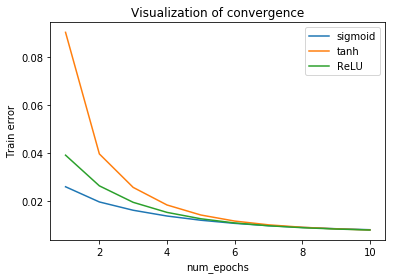

Epoch [1/10], Loss_error: 0.0471
Epoch [2/10], Loss_error: 0.0462
Epoch [3/10], Loss_error: 0.0456
Epoch [4/10], Loss_error: 0.0450
Epoch [5/10], Loss_error: 0.0443
Epoch [6/10], Loss_error: 0.0436
Epoch [7/10], Loss_error: 0.0428
Epoch [8/10], Loss_error: 0.0421
Epoch [9/10], Loss_error: 0.0412
Epoch [10/10], Loss_error: 0.0401
The loss on validation set is: 0.02009860798716545
Epoch [1/10], Loss_error: 0.0473
Epoch [2/10], Loss_error: 0.0315
Epoch [3/10], Loss_error: 0.0263
Epoch [4/10], Loss_error: 0.0217
Epoch [5/10], Loss_error: 0.0175
Epoch [6/10], Loss_error: 0.0140
Epoch [7/10], Loss_error: 0.0113
Epoch [8/10], Loss_error: 0.0095
Epoch [9/10], Loss_error: 0.0083
Epoch [10/10], Loss_error: 0.0076
The loss on validation set is: 0.005777569487690926
Epoch [1/10], Loss_error: 0.0560
Epoch [2/10], Loss_error: 0.0427
Epoch [3/10], Loss_error: 0.0365
Epoch [4/10], Loss_error: 0.0314
Epoch [5/10], Loss_error: 0.0267
Epoch [6/10], Loss_error: 0.0224
Epoch [7/10], Loss_error: 0.0184
Epoc

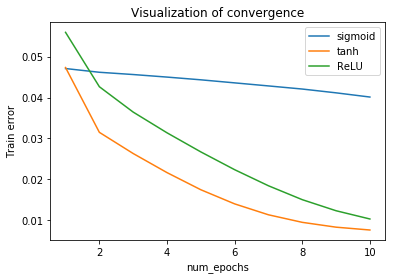

Epoch [1/10], Loss_error: 0.0480
Epoch [2/10], Loss_error: 0.0473
Epoch [3/10], Loss_error: 0.0472
Epoch [4/10], Loss_error: 0.0472
Epoch [5/10], Loss_error: 0.0473
Epoch [6/10], Loss_error: 0.0472
Epoch [7/10], Loss_error: 0.0472
Epoch [8/10], Loss_error: 0.0471
Epoch [9/10], Loss_error: 0.0471
Epoch [10/10], Loss_error: 0.0471
The loss on validation set is: 0.023933809250593185
Epoch [1/10], Loss_error: 0.0398
Epoch [2/10], Loss_error: 0.0259
Epoch [3/10], Loss_error: 0.0163
Epoch [4/10], Loss_error: 0.0110
Epoch [5/10], Loss_error: 0.0085
Epoch [6/10], Loss_error: 0.0074
Epoch [7/10], Loss_error: 0.0071
Epoch [8/10], Loss_error: 0.0069
Epoch [9/10], Loss_error: 0.0069
Epoch [10/10], Loss_error: 0.0069
The loss on validation set is: 0.005775396712124348
Epoch [1/10], Loss_error: 0.0464
Epoch [2/10], Loss_error: 0.0454
Epoch [3/10], Loss_error: 0.0443
Epoch [4/10], Loss_error: 0.0428
Epoch [5/10], Loss_error: 0.0407
Epoch [6/10], Loss_error: 0.0375
Epoch [7/10], Loss_error: 0.0331
Epo

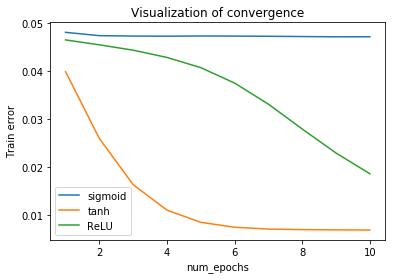

Epoch [1/10], Loss_error: 0.0472
Epoch [2/10], Loss_error: 0.0465
Epoch [3/10], Loss_error: 0.0465
Epoch [4/10], Loss_error: 0.0465
Epoch [5/10], Loss_error: 0.0465
Epoch [6/10], Loss_error: 0.0465
Epoch [7/10], Loss_error: 0.0465
Epoch [8/10], Loss_error: 0.0465
Epoch [9/10], Loss_error: 0.0465
Epoch [10/10], Loss_error: 0.0465
The loss on validation set is: 0.025411086156964302
Epoch [1/10], Loss_error: 0.0467
Epoch [2/10], Loss_error: 0.0417
Epoch [3/10], Loss_error: 0.0386
Epoch [4/10], Loss_error: 0.0334
Epoch [5/10], Loss_error: 0.0263
Epoch [6/10], Loss_error: 0.0204
Epoch [7/10], Loss_error: 0.0167
Epoch [8/10], Loss_error: 0.0138
Epoch [9/10], Loss_error: 0.0112
Epoch [10/10], Loss_error: 0.0093
The loss on validation set is: 0.006426254753023386
Epoch [1/10], Loss_error: 0.0458
Epoch [2/10], Loss_error: 0.0452
Epoch [3/10], Loss_error: 0.0447
Epoch [4/10], Loss_error: 0.0442
Epoch [5/10], Loss_error: 0.0434
Epoch [6/10], Loss_error: 0.0422
Epoch [7/10], Loss_error: 0.0404
Epo

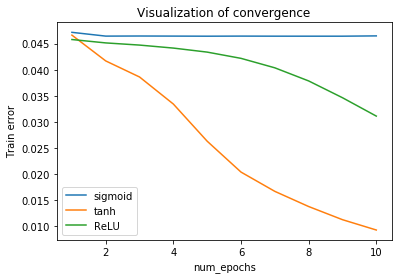

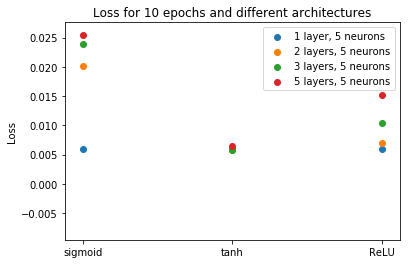

In [63]:
import numpy as np 

# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 10

models_names=['1 layer, 5 neurons','2 layers, 5 neurons','3 layers, 5 neurons','5 layers, 5 neurons']
models=[Model,Model_2,Model_3,Model_5]

acti_names=["sigmoid","tanh","ReLU"]
acti=[torch.sigmoid,torch.tanh,torch.nn.functional.relu]

errors=[]

for mod in models:
    errors_mod=[]
    for i in range(len(acti)):
        activation=acti[i]
        
        model=mod(5,activation)
        
        criterion = nn.MSELoss()

        # Use SGD optimizer with a learning rate of 0.01
        # It is initialized on our model
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

        train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set)

        # plot the training error wrt. the number of epochs: 
        plt.plot(range(1, num_epochs+1), train_error, label=acti_names[i])
        plt.xlabel("num_epochs")
        plt.ylabel("Train error")
        plt.title("Visualization of convergence")


        model.eval()
        errors_mod.append(accuracy(X_val,y_val, model))
    plt.legend()
    plt.show()
    
    errors.append(errors_mod)

# Figure for the accuracy
for i in range(len(errors)):
    plt.scatter(np.arange(len(acti)),errors[i],label=models_names[i])
    
plt.title("Loss for 10 epochs and different architectures")
plt.xticks(np.arange(len(acti)), acti_names)
plt.ylabel("Loss")
plt.legend()
plt.show()

Epoch [1/10], Loss_error: 0.0762
Epoch [2/10], Loss_error: 0.0464
Epoch [3/10], Loss_error: 0.0453
Epoch [4/10], Loss_error: 0.0439
Epoch [5/10], Loss_error: 0.0418
Epoch [6/10], Loss_error: 0.0385
Epoch [7/10], Loss_error: 0.0337
Epoch [8/10], Loss_error: 0.0281
Epoch [9/10], Loss_error: 0.0232
Epoch [10/10], Loss_error: 0.0192
The loss on validation set is: 0.010246224701404572
Epoch [1/10], Loss_error: 0.0458
Epoch [2/10], Loss_error: 0.0308
Epoch [3/10], Loss_error: 0.0253
Epoch [4/10], Loss_error: 0.0212
Epoch [5/10], Loss_error: 0.0178
Epoch [6/10], Loss_error: 0.0147
Epoch [7/10], Loss_error: 0.0120
Epoch [8/10], Loss_error: 0.0100
Epoch [9/10], Loss_error: 0.0086
Epoch [10/10], Loss_error: 0.0077
The loss on validation set is: 0.005918917711824179
Epoch [1/10], Loss_error: 0.0457
Epoch [2/10], Loss_error: 0.0440
Epoch [3/10], Loss_error: 0.0417
Epoch [4/10], Loss_error: 0.0376
Epoch [5/10], Loss_error: 0.0308
Epoch [6/10], Loss_error: 0.0220
Epoch [7/10], Loss_error: 0.0144
Epo

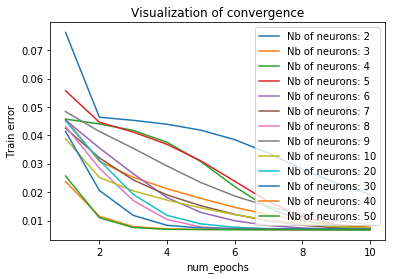

Epoch [1/10], Loss_error: 0.0462
Epoch [2/10], Loss_error: 0.0462
Epoch [3/10], Loss_error: 0.0461
Epoch [4/10], Loss_error: 0.0460
Epoch [5/10], Loss_error: 0.0459
Epoch [6/10], Loss_error: 0.0458
Epoch [7/10], Loss_error: 0.0456
Epoch [8/10], Loss_error: 0.0454
Epoch [9/10], Loss_error: 0.0451
Epoch [10/10], Loss_error: 0.0447
The loss on validation set is: 0.024275653064250946
Epoch [1/10], Loss_error: 0.0509
Epoch [2/10], Loss_error: 0.0482
Epoch [3/10], Loss_error: 0.0477
Epoch [4/10], Loss_error: 0.0474
Epoch [5/10], Loss_error: 0.0471
Epoch [6/10], Loss_error: 0.0470
Epoch [7/10], Loss_error: 0.0469
Epoch [8/10], Loss_error: 0.0467
Epoch [9/10], Loss_error: 0.0467
Epoch [10/10], Loss_error: 0.0466
The loss on validation set is: 0.02538776770234108
Epoch [1/10], Loss_error: 0.0636
Epoch [2/10], Loss_error: 0.0443
Epoch [3/10], Loss_error: 0.0432
Epoch [4/10], Loss_error: 0.0416
Epoch [5/10], Loss_error: 0.0384
Epoch [6/10], Loss_error: 0.0322
Epoch [7/10], Loss_error: 0.0218
Epoc

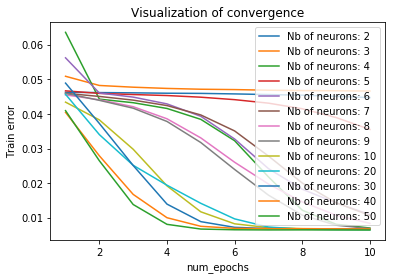

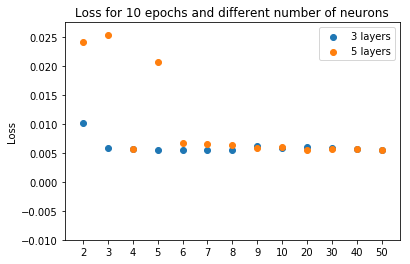

In [65]:
import numpy as np 

# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 10
activation = torch.tanh

models_names=['3 layers','5 layers']
models=[Model_3,Model_5]

neurons=[2,3,4,5,6,7,8,9,10,20,30,40,50]

errors=[]

for mod in models:
    errors_mod=[]
    for n_neurons in neurons:

        model=mod(n_neurons,activation)
        
        criterion = nn.MSELoss()

        # Use SGD optimizer with a learning rate of 0.01
        # It is initialized on our model
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

        train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set)

        # plot the training error wrt. the number of epochs: 
        plt.plot(range(1, num_epochs+1), train_error, label="Nb of neurons: "+str(n_neurons))
        plt.xlabel("num_epochs")
        plt.ylabel("Train error")
        plt.title("Visualization of convergence")


        model.eval()
        errors_mod.append(accuracy(X_val,y_val, model))
    plt.legend()
    plt.show()
    
    errors.append(errors_mod)

# Figure for the loss
for i in range(len(errors)):
    plt.scatter(np.arange(len(neurons)),errors[i],label=models_names[i])
    
plt.title("Loss for 10 epochs and different number of neurons")
plt.xticks(np.arange(len(neurons)), neurons)
plt.ylabel("Loss")
plt.legend()
plt.show()

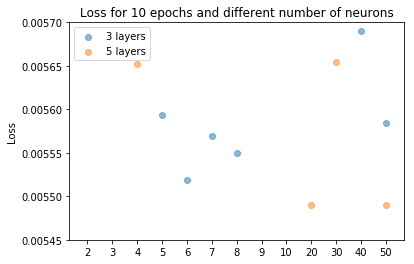

In [72]:
# Figure for the accuracy
for i in range(len(errors)):
    plt.scatter(np.arange(len(neurons)),errors[i],label=models_names[i],alpha=.5)
    
plt.title("Loss for 10 epochs and different number of neurons")
plt.xticks(np.arange(len(neurons)), neurons)
plt.ylabel("Loss")
plt.ylim(ymin=0.00545,ymax=0.0057)
plt.legend()
plt.show()

### Question 2

Epoch [1/10], Loss_error: 0.0463
Epoch [2/10], Loss_error: 0.0444
Epoch [3/10], Loss_error: 0.0428
Epoch [4/10], Loss_error: 0.0403
Epoch [5/10], Loss_error: 0.0365
Epoch [6/10], Loss_error: 0.0321
Epoch [7/10], Loss_error: 0.0269
Epoch [8/10], Loss_error: 0.0204
Epoch [9/10], Loss_error: 0.0137
Epoch [10/10], Loss_error: 0.0093
The loss on validation set is: 0.006013709120452404
Epoch [1/10], Loss_error: 0.0755
Epoch [2/10], Loss_error: 0.0462
Epoch [3/10], Loss_error: 0.0458
Epoch [4/10], Loss_error: 0.0454
Epoch [5/10], Loss_error: 0.0451
Epoch [6/10], Loss_error: 0.0447
Epoch [7/10], Loss_error: 0.0442
Epoch [8/10], Loss_error: 0.0438
Epoch [9/10], Loss_error: 0.0433
Epoch [10/10], Loss_error: 0.0428
The loss on validation set is: 0.022409092634916306
Epoch [1/10], Loss_error: 0.0561
Epoch [2/10], Loss_error: 0.0453
Epoch [3/10], Loss_error: 0.0452
Epoch [4/10], Loss_error: 0.0451
Epoch [5/10], Loss_error: 0.0450
Epoch [6/10], Loss_error: 0.0449
Epoch [7/10], Loss_error: 0.0447
Epo

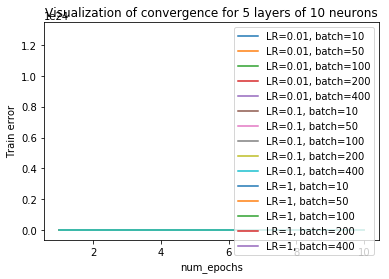

Epoch [1/10], Loss_error: 0.0486
Epoch [2/10], Loss_error: 0.0436
Epoch [3/10], Loss_error: 0.0386
Epoch [4/10], Loss_error: 0.0309
Epoch [5/10], Loss_error: 0.0215
Epoch [6/10], Loss_error: 0.0128
Epoch [7/10], Loss_error: 0.0079
Epoch [8/10], Loss_error: 0.0068
Epoch [9/10], Loss_error: 0.0067
Epoch [10/10], Loss_error: 0.0067
The loss on validation set is: 0.005634286906570196
Epoch [1/10], Loss_error: 0.0550
Epoch [2/10], Loss_error: 0.0464
Epoch [3/10], Loss_error: 0.0462
Epoch [4/10], Loss_error: 0.0460
Epoch [5/10], Loss_error: 0.0458
Epoch [6/10], Loss_error: 0.0456
Epoch [7/10], Loss_error: 0.0453
Epoch [8/10], Loss_error: 0.0451
Epoch [9/10], Loss_error: 0.0448
Epoch [10/10], Loss_error: 0.0445
The loss on validation set is: 0.025167567655444145
Epoch [1/10], Loss_error: 0.0568
Epoch [2/10], Loss_error: 0.0477
Epoch [3/10], Loss_error: 0.0470
Epoch [4/10], Loss_error: 0.0463
Epoch [5/10], Loss_error: 0.0457
Epoch [6/10], Loss_error: 0.0450
Epoch [7/10], Loss_error: 0.0444
Epo

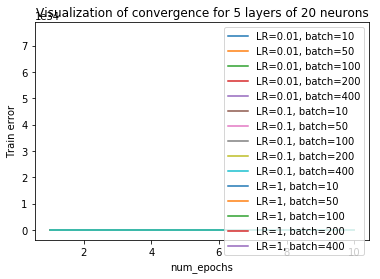

Epoch [1/10], Loss_error: 0.0442
Epoch [2/10], Loss_error: 0.0311
Epoch [3/10], Loss_error: 0.0163
Epoch [4/10], Loss_error: 0.0087
Epoch [5/10], Loss_error: 0.0069
Epoch [6/10], Loss_error: 0.0066
Epoch [7/10], Loss_error: 0.0065
Epoch [8/10], Loss_error: 0.0065
Epoch [9/10], Loss_error: 0.0065
Epoch [10/10], Loss_error: 0.0064
The loss on validation set is: 0.005421844776719809
Epoch [1/10], Loss_error: 0.0537
Epoch [2/10], Loss_error: 0.0426
Epoch [3/10], Loss_error: 0.0408
Epoch [4/10], Loss_error: 0.0389
Epoch [5/10], Loss_error: 0.0368
Epoch [6/10], Loss_error: 0.0344
Epoch [7/10], Loss_error: 0.0318
Epoch [8/10], Loss_error: 0.0290
Epoch [9/10], Loss_error: 0.0262
Epoch [10/10], Loss_error: 0.0233
The loss on validation set is: 0.012883888557553291
Epoch [1/10], Loss_error: 0.0608
Epoch [2/10], Loss_error: 0.0505
Epoch [3/10], Loss_error: 0.0488
Epoch [4/10], Loss_error: 0.0474
Epoch [5/10], Loss_error: 0.0461
Epoch [6/10], Loss_error: 0.0448
Epoch [7/10], Loss_error: 0.0435
Epo

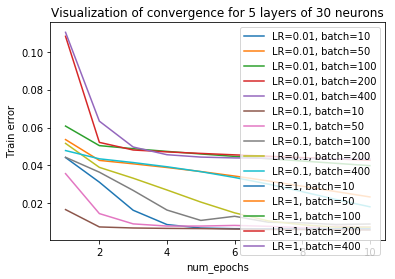

Epoch [1/10], Loss_error: 0.0412
Epoch [2/10], Loss_error: 0.0245
Epoch [3/10], Loss_error: 0.0122
Epoch [4/10], Loss_error: 0.0077
Epoch [5/10], Loss_error: 0.0067
Epoch [6/10], Loss_error: 0.0065
Epoch [7/10], Loss_error: 0.0064
Epoch [8/10], Loss_error: 0.0064
Epoch [9/10], Loss_error: 0.0064
Epoch [10/10], Loss_error: 0.0064
The loss on validation set is: 0.00547506520524621
Epoch [1/10], Loss_error: 0.0520
Epoch [2/10], Loss_error: 0.0466
Epoch [3/10], Loss_error: 0.0442
Epoch [4/10], Loss_error: 0.0417
Epoch [5/10], Loss_error: 0.0391
Epoch [6/10], Loss_error: 0.0363
Epoch [7/10], Loss_error: 0.0332
Epoch [8/10], Loss_error: 0.0300
Epoch [9/10], Loss_error: 0.0265
Epoch [10/10], Loss_error: 0.0231
The loss on validation set is: 0.012671148404479027
Epoch [1/10], Loss_error: 0.0718
Epoch [2/10], Loss_error: 0.0407
Epoch [3/10], Loss_error: 0.0389
Epoch [4/10], Loss_error: 0.0371
Epoch [5/10], Loss_error: 0.0353
Epoch [6/10], Loss_error: 0.0336
Epoch [7/10], Loss_error: 0.0317
Epoc

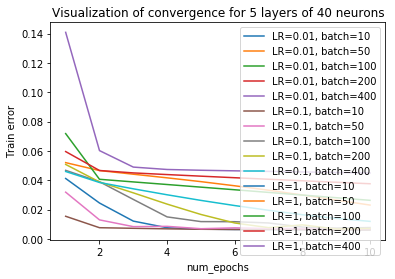

Epoch [1/10], Loss_error: 0.0403
Epoch [2/10], Loss_error: 0.0263
Epoch [3/10], Loss_error: 0.0144
Epoch [4/10], Loss_error: 0.0082
Epoch [5/10], Loss_error: 0.0070
Epoch [6/10], Loss_error: 0.0069
Epoch [7/10], Loss_error: 0.0069
Epoch [8/10], Loss_error: 0.0068
Epoch [9/10], Loss_error: 0.0068
Epoch [10/10], Loss_error: 0.0068
The loss on validation set is: 0.0056068249978125095
Epoch [1/10], Loss_error: 0.0461
Epoch [2/10], Loss_error: 0.0405
Epoch [3/10], Loss_error: 0.0375
Epoch [4/10], Loss_error: 0.0343
Epoch [5/10], Loss_error: 0.0308
Epoch [6/10], Loss_error: 0.0269
Epoch [7/10], Loss_error: 0.0230
Epoch [8/10], Loss_error: 0.0192
Epoch [9/10], Loss_error: 0.0159
Epoch [10/10], Loss_error: 0.0133
The loss on validation set is: 0.007793161552399397
Epoch [1/10], Loss_error: 0.0784
Epoch [2/10], Loss_error: 0.0467
Epoch [3/10], Loss_error: 0.0450
Epoch [4/10], Loss_error: 0.0435
Epoch [5/10], Loss_error: 0.0419
Epoch [6/10], Loss_error: 0.0404
Epoch [7/10], Loss_error: 0.0389
Ep

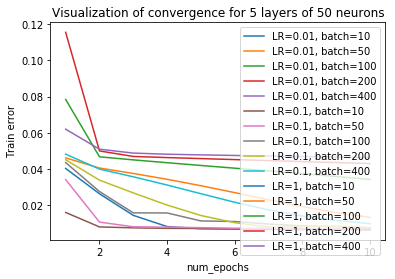

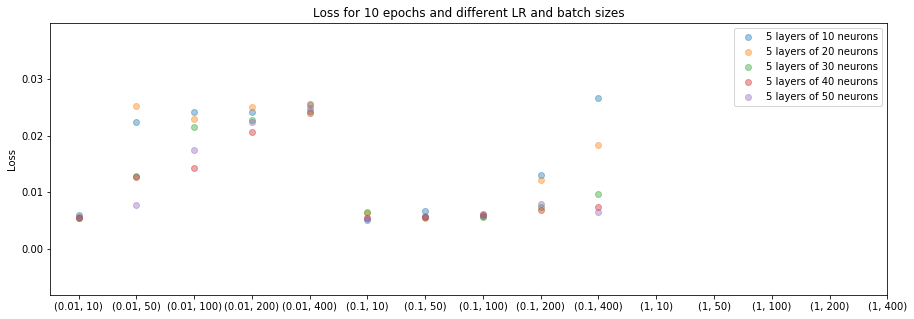

In [81]:
import numpy as np 

# Choose the hyperparameters for training: 
num_epochs = 10
activation = torch.tanh

neurons=[10,20,30,40,50]

params=[(0.01,10),(0.01,50),(0.01,100),(0.01,200),(0.01,400),\
        (0.1,10),(0.1,50),(0.1,100),(0.1,200),(0.1,400),\
        (1,10),(1,50),(1,100),(1,200),(1,400)]

errors=[]

for n_neurons in neurons:
    errors_mod=[]
    for (learning_rate,batch) in (params):

        model=Model_5(n_neurons,activation)
        
        criterion = nn.MSELoss()

        # Use SGD optimizer with a learning rate of 0.01
        # It is initialized on our model
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

        train_error = train(num_epochs, batch, criterion, optimizer, model, train_set)

        # plot the training error wrt. the number of epochs: 
        plt.plot(range(1, num_epochs+1), train_error, label="LR="+str(learning_rate)+", batch="+str(batch))
        plt.xlabel("num_epochs")
        plt.ylabel("Train error")
        plt.title("Visualization of convergence for 5 layers of "+str(n_neurons)+" neurons")


        model.eval()
        errors_mod.append(accuracy(X_val,y_val, model))
    plt.legend()
    plt.show()
    
    errors.append(errors_mod)


plt.figure(figsize=(15,5))
# Figure for the loss
for i in range(len(errors)):
    plt.scatter(np.arange(len(params)),errors[i],label="5 layers of "+str(neurons[i])+" neurons",alpha=0.4)
    
plt.title("Loss for 10 epochs and different LR and batch sizes")
plt.xticks(np.arange(len(params)), params)
plt.ylabel("Loss")
plt.legend()
plt.show()

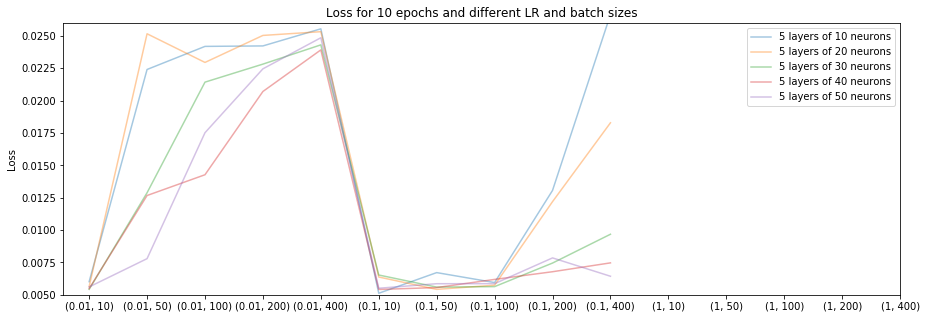

In [86]:
plt.figure(figsize=(15,5))
# Figure for the loss
for i in range(len(errors)):
    plt.plot(np.arange(len(params)),errors[i],label="5 layers of "+str(neurons[i])+" neurons",alpha=0.4)
    
plt.title("Loss for 10 epochs and different LR and batch sizes")
plt.xticks(np.arange(len(params)), params)
plt.ylabel("Loss")
plt.ylim(ymin=0.005,ymax=0.026)
plt.legend()
plt.show()

Epoch [1/20], Loss_error: 0.0814
Epoch [2/20], Loss_error: 0.0474
Epoch [3/20], Loss_error: 0.0469
Epoch [4/20], Loss_error: 0.0468
Epoch [5/20], Loss_error: 0.0466
Epoch [6/20], Loss_error: 0.0465
Epoch [7/20], Loss_error: 0.0464
Epoch [8/20], Loss_error: 0.0463
Epoch [9/20], Loss_error: 0.0461
Epoch [10/20], Loss_error: 0.0460
Epoch [11/20], Loss_error: 0.0459
Epoch [12/20], Loss_error: 0.0457
Epoch [13/20], Loss_error: 0.0456
Epoch [14/20], Loss_error: 0.0454
Epoch [15/20], Loss_error: 0.0453
Epoch [16/20], Loss_error: 0.0452
Epoch [17/20], Loss_error: 0.0450
Epoch [18/20], Loss_error: 0.0448
Epoch [19/20], Loss_error: 0.0447
Epoch [20/20], Loss_error: 0.0445
The loss on validation set is: 0.023926762863993645
Epoch [1/20], Loss_error: 0.0534
Epoch [2/20], Loss_error: 0.0444
Epoch [3/20], Loss_error: 0.0433
Epoch [4/20], Loss_error: 0.0419
Epoch [5/20], Loss_error: 0.0401
Epoch [6/20], Loss_error: 0.0376
Epoch [7/20], Loss_error: 0.0343
Epoch [8/20], Loss_error: 0.0300
Epoch [9/20],

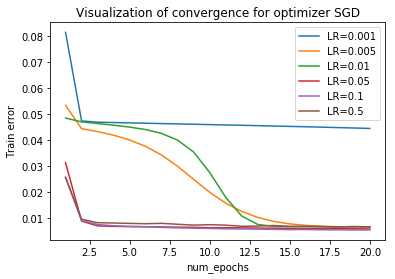

Epoch [1/20], Loss_error: 0.0268
Epoch [2/20], Loss_error: 0.0069
Epoch [3/20], Loss_error: 0.0065
Epoch [4/20], Loss_error: 0.0061
Epoch [5/20], Loss_error: 0.0057
Epoch [6/20], Loss_error: 0.0056
Epoch [7/20], Loss_error: 0.0055
Epoch [8/20], Loss_error: 0.0055
Epoch [9/20], Loss_error: 0.0053
Epoch [10/20], Loss_error: 0.0052
Epoch [11/20], Loss_error: 0.0051
Epoch [12/20], Loss_error: 0.0050
Epoch [13/20], Loss_error: 0.0050
Epoch [14/20], Loss_error: 0.0049
Epoch [15/20], Loss_error: 0.0049
Epoch [16/20], Loss_error: 0.0047
Epoch [17/20], Loss_error: 0.0047
Epoch [18/20], Loss_error: 0.0046
Epoch [19/20], Loss_error: 0.0047
Epoch [20/20], Loss_error: 0.0045
The loss on validation set is: 0.004297198727726936
Epoch [1/20], Loss_error: 0.0157
Epoch [2/20], Loss_error: 0.0061
Epoch [3/20], Loss_error: 0.0060
Epoch [4/20], Loss_error: 0.0056
Epoch [5/20], Loss_error: 0.0051
Epoch [6/20], Loss_error: 0.0049
Epoch [7/20], Loss_error: 0.0049
Epoch [8/20], Loss_error: 0.0050
Epoch [9/20],

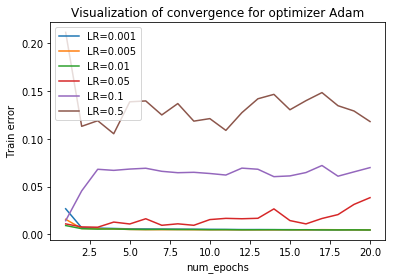

Epoch [1/20], Loss_error: 0.0123
Epoch [2/20], Loss_error: 0.0068
Epoch [3/20], Loss_error: 0.0061
Epoch [4/20], Loss_error: 0.0058
Epoch [5/20], Loss_error: 0.0057
Epoch [6/20], Loss_error: 0.0056
Epoch [7/20], Loss_error: 0.0055
Epoch [8/20], Loss_error: 0.0054
Epoch [9/20], Loss_error: 0.0052
Epoch [10/20], Loss_error: 0.0050
Epoch [11/20], Loss_error: 0.0049
Epoch [12/20], Loss_error: 0.0048
Epoch [13/20], Loss_error: 0.0047
Epoch [14/20], Loss_error: 0.0046
Epoch [15/20], Loss_error: 0.0045
Epoch [16/20], Loss_error: 0.0045
Epoch [17/20], Loss_error: 0.0045
Epoch [18/20], Loss_error: 0.0044
Epoch [19/20], Loss_error: 0.0044
Epoch [20/20], Loss_error: 0.0044
The loss on validation set is: 0.004210552666336298
Epoch [1/20], Loss_error: 0.0116
Epoch [2/20], Loss_error: 0.0069
Epoch [3/20], Loss_error: 0.0066
Epoch [4/20], Loss_error: 0.0060
Epoch [5/20], Loss_error: 0.0056
Epoch [6/20], Loss_error: 0.0054
Epoch [7/20], Loss_error: 0.0053
Epoch [8/20], Loss_error: 0.0052
Epoch [9/20],

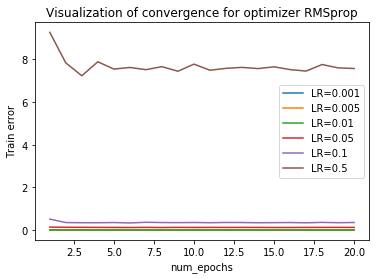

Epoch [1/20], Loss_error: 0.0806
Epoch [2/20], Loss_error: 0.0429
Epoch [3/20], Loss_error: 0.0414
Epoch [4/20], Loss_error: 0.0401
Epoch [5/20], Loss_error: 0.0389
Epoch [6/20], Loss_error: 0.0376
Epoch [7/20], Loss_error: 0.0365
Epoch [8/20], Loss_error: 0.0353
Epoch [9/20], Loss_error: 0.0342
Epoch [10/20], Loss_error: 0.0331
Epoch [11/20], Loss_error: 0.0321
Epoch [12/20], Loss_error: 0.0312
Epoch [13/20], Loss_error: 0.0304
Epoch [14/20], Loss_error: 0.0296
Epoch [15/20], Loss_error: 0.0289
Epoch [16/20], Loss_error: 0.0282
Epoch [17/20], Loss_error: 0.0276
Epoch [18/20], Loss_error: 0.0270
Epoch [19/20], Loss_error: 0.0265
Epoch [20/20], Loss_error: 0.0260
The loss on validation set is: 0.014873121865093708
Epoch [1/20], Loss_error: 0.0185
Epoch [2/20], Loss_error: 0.0068
Epoch [3/20], Loss_error: 0.0067
Epoch [4/20], Loss_error: 0.0067
Epoch [5/20], Loss_error: 0.0066
Epoch [6/20], Loss_error: 0.0066
Epoch [7/20], Loss_error: 0.0065
Epoch [8/20], Loss_error: 0.0065
Epoch [9/20],

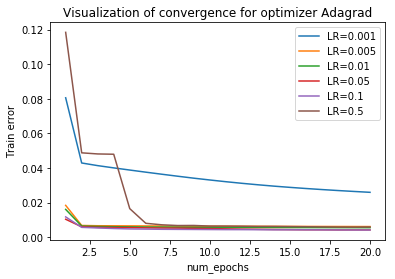

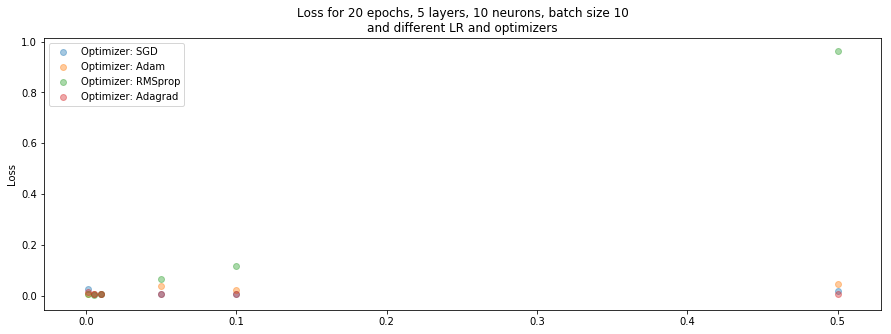

In [101]:
# Choose the hyperparameters for training: 
num_epochs = 20
batch_size = 10
activation = torch.tanh
n_neurons = 10

optimizers_names=['SGD','Adam','RMSprop','Adagrad']
optimizers=[torch.optim.SGD,torch.optim.Adam,torch.optim.RMSprop,torch.optim.Adagrad]
learning_rates=[0.001,0.005,0.01,0.05,0.1,0.5]

errors=[]

for i in range(len(optimizers)):
    errors_mod=[]
    for learning_rate in learning_rates:

        model=Model_5(n_neurons,activation)
        
        criterion = nn.MSELoss()

        # Use SGD optimizer with a learning rate of 0.01
        # It is initialized on our model
        opti=optimizers[i]
        optimizer = opti(model.parameters(), lr=learning_rate)

        train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set)

        # plot the training error wrt. the number of epochs: 
        plt.plot(range(1, num_epochs+1), train_error, label="LR="+str(learning_rate))
        plt.xlabel("num_epochs")
        plt.ylabel("Train error")
        plt.title("Visualization of convergence for optimizer "+str(optimizers_names[i]))


        model.eval()
        errors_mod.append(accuracy(X_val,y_val, model))
    plt.legend()
    plt.show()
    
    errors.append(errors_mod)


plt.figure(figsize=(15,5))
# Figure for the loss
for i in range(len(errors)):
    plt.scatter(learning_rates,errors[i],label="Optimizer: "+str(optimizers_names[i]),alpha=0.4)
    
plt.title("Loss for 20 epochs, 5 layers, 10 neurons, batch size 10\nand different LR and optimizers")
plt.ylabel("Loss")
plt.legend()
plt.show()

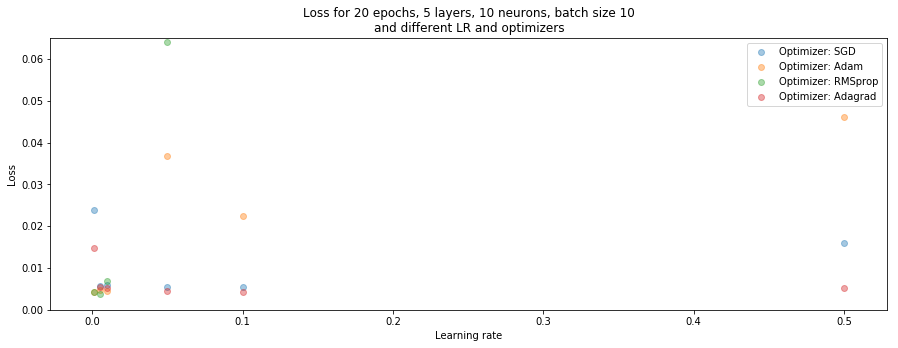

In [169]:
plt.figure(figsize=(15,5))
# Figure for the loss
for i in range(len(errors)):
    plt.scatter(learning_rates,errors[i],label="Optimizer: "+str(optimizers_names[i]),alpha=0.4)
    
plt.title("Loss for 20 epochs, 5 layers, 10 neurons, batch size 10\nand different LR and optimizers")
plt.ylabel("Loss")
plt.xlabel("Learning rate")
plt.legend()
plt.ylim(ymin=0,ymax=0.065)
plt.show()

### Question 3

In [135]:
class Model_5(nn.Module):
    
    def __init__(self,neurons,acti):
        super(Model_5, self).__init__()
        self.l1 = nn.Linear(3, neurons)
        self.l2 = nn.Linear(neurons, neurons)
        self.l3 = nn.Linear(neurons, neurons)
        self.l4 = nn.Linear(neurons, neurons)
        self.l5 = nn.Linear(neurons, neurons)
        self.acti=acti
        
    def forward(self, inputs):
        outputs = self.l1(inputs)
        outputs=self.acti(outputs)
        outputs = self.l2(outputs)
        outputs=self.acti(outputs)
        outputs = self.l3(outputs)
        outputs=self.acti(outputs)
        outputs = self.l4(outputs)
        outputs=self.acti(outputs)
        outputs = self.l5(outputs)

        return outputs.mean(1),torch.log(outputs.std(1)**2)

 $$L =\sum\limits_{i=1}^{N}  \frac{1}{2} \log ( 2\pi\sigma_i^{2} ) + \frac{1}{2\sigma_i^{2}}  (y_{i} - \mu_i)^{2}$$ 

In [158]:
import math
from torch.nn.modules import Module

class _Loss(Module):
    def __init__(self, size_average=None, reduce=None, reduction='mean'):
        super(_Loss, self).__init__()
        if size_average is not None or reduce is not None:
            self.reduction = _Reduction.legacy_get_string(size_average, reduce)
        else:
            self.reduction = reduction


class GaussianLoss(_Loss):
    
    __constants__ = ['reduction']

    def __init__(self, size_average=None, reduce=None, reduction='mean'):
        super(GaussianLoss, self).__init__(size_average, reduce, reduction)

    def forward(self, input_mean, input_std, target):
        n = input_mean.shape[0]
        
        losses = 0.5*(np.log(2*math.pi) + input_std) + (1 / (2*torch.exp(input_std)))*(target - input_mean)**2

        return torch.sum(losses)/n


#### Redifining te accuracy and train functions

In [155]:
# Calculate mean squared error on validation set
def accuracy(X_val,y_val,model):
    with torch.no_grad():
        y_pre_val_mean,y_pre_val_std = model(torch.from_numpy(np.array(X_val)).float())
        
    error = criterion(y_pre_val_mean, y_pre_val_std, torch.tensor(np.array(y_val)).float()).item()
    print('The loss on validation set is:', error)
    return error

In [156]:
def train(num_epochs, batch_size, criterion, optimizer, model, dataset):
    train_error = []
    
    dataloader = DataLoader(dataset, batch_size, shuffle=True)

    model.train()
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (X, y) in (dataloader):

            y_pre_mean,y_pre_std = model(X)
            
            loss = criterion(y_pre_mean,y_pre_std, y)
            
            optimizer.zero_grad()
            loss.backward()
            
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(train_set)
            
        if ((epoch+1)%1 == 0):
            print('Epoch [{}/{}], Loss_error: {:.4f}'
                      .format(epoch+1, num_epochs,  epoch_average_loss))
            train_error.append(epoch_average_loss)
            
    return train_error

Epoch [1/100], Loss_error: -0.8817
Epoch [2/100], Loss_error: -1.1797
Epoch [3/100], Loss_error: -1.1986
Epoch [4/100], Loss_error: -1.2387
Epoch [5/100], Loss_error: -1.2719
Epoch [6/100], Loss_error: -1.2994
Epoch [7/100], Loss_error: -1.3211
Epoch [8/100], Loss_error: -1.3394
Epoch [9/100], Loss_error: -1.3508
Epoch [10/100], Loss_error: -1.3735
Epoch [11/100], Loss_error: -1.3836
Epoch [12/100], Loss_error: -1.3905
Epoch [13/100], Loss_error: -1.3986
Epoch [14/100], Loss_error: -1.4165
Epoch [15/100], Loss_error: -1.4243
Epoch [16/100], Loss_error: -1.4418
Epoch [17/100], Loss_error: -1.4371
Epoch [18/100], Loss_error: -1.4529
Epoch [19/100], Loss_error: -1.4607
Epoch [20/100], Loss_error: -1.4732
Epoch [21/100], Loss_error: -1.4801
Epoch [22/100], Loss_error: -1.4822
Epoch [23/100], Loss_error: -1.4935
Epoch [24/100], Loss_error: -1.4809
Epoch [25/100], Loss_error: -1.4938
Epoch [26/100], Loss_error: -1.4972
Epoch [27/100], Loss_error: -1.5030
Epoch [28/100], Loss_error: -1.5063
E

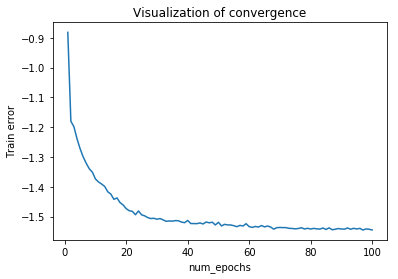

In [170]:
# Choose the hyperparameters for training: 
num_epochs = 100
batch_size = 10
activation = torch.tanh
n_neurons = 10
learning_rate = 0.001


model=Model_5(n_neurons,activation)

criterion = GaussianLoss()

optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set)

# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")


model.eval()
accuracy(X_val,y_val, model)

plt.show()

### Question 4

#### On test set

In [172]:
model.eval()
accuracy(X_test,y_test, model)

The loss on validation set is: -1.369850754737854


-1.369850754737854

#### Evaluate the Model on the validation set

In [37]:
# Calculate mean squared error on validation set
model.eval()
with torch.no_grad():
    y_pre_val = model(torch.from_numpy(np.array(X_val)).float()).view(-1)
error = criterion(y_pre_val, torch.tensor(np.array(y_val)).float()).item()
print('The loss on validation set is:', error)

The loss on validation set is: 0.006231800187379122


### Exercise 1: Impact of the architecture of the model

The class `Model` is the definition of your model. You can now modify it to try out different architectures and
see the impact of the following factors:

* Try to add more layers (1, 2, 3, more ?)
* Try different activation functions ([sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.)
* Try to change the number of neurons in each layer (5, 10, 20, more ?)

### Exercise 2: Impact of the optimizer

Retrain the model with different parameters of the optimizer; you can change then in the cell initializing the optimizer, after the definition of your model.

* Use different batch sizes, from 10 to 400 e.g.
* Try different values of the learning rate (between 0.001 and 10), and see how they impact the training process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

**Note:** These changes may interact with your previous choices of architectures, and you may need to change them as well!

### Exercise 3: Impact of the loss function
As mensioned before in the first problem (binary classification), one can minimize the negative of log-likelihood of the probability for all samples $x$: $$ \sum_{(x,y) \,\in\, \text{Dataset}} - \log p(y | x) $$ If we define $p(y_i | x_i) = \frac{1}{\sqrt{2\pi}}e^{-\frac{(y_i - f(x_i))^2}{2}}$, then the loss function becomes the mean squared error. 

There is another loss function worth to try: the Gaussian likelihood loss function. 
Rather than predicting a single value $y$ given $x$, we predict a probability distribution over possible answers, which helps dealing with ambiguous cases and expressing uncertainty. To do this, for each possible input $x$, the network will output the parameters of the distribution modeling $p(y|x)$. For instance in our case, we choose to model output distributions with Gaussian distributions $\mathcal{N}(\mu, \sigma)$, which are parameterized by their mean $\mu$ and their standard deviation $\sigma$. Therefore for each input $x$ we have to output two quantities: $\mu(x)$ and $\sigma(x)$. The probability becomes: $$p(y_i | x_i) = \frac{1}{\sqrt{2\pi \sigma(x_i)^2}}e^{-\frac{(y_i - \mu(x_i))^2}{2\sigma(x_i)^2}}$$ Then the loss function becomes: $$L =\sum\limits_{i=1}^{N}  \frac{1}{2} \log ( 2\pi\sigma_i^{2} ) + \frac{1}{2\sigma_i^{2}}  (y_{i} - \mu_i)^{2}$$ If we set $\sigma=1$, we obtain MSE the loss function. 

* Try to replace the loss function with this one, and compare the differences between the two losses.
 
* **Hints**: 
    * You need two outputs of your network, one represents the $\mu(x_i)$, another for $\log( \sigma(x_i)^2 )$ (better for optimization) 
    * Try deeper models, or you will not predict the variance $\sigma$ well. 


### Exercice 4: Prediction on test set

* Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.
* When using the Gaussian likelihood function, the confidence of the network in its prediction is reflected in the variance it outputs. It can be interesting to check how this uncertainty varies with the data. For example, the uncertainty will decrease when the feature `FR_radiation_direct_horizontal` increases. Plot the variance $\sigma(x)$ w.r.t one of the three features, on test set, and describe what you observe.